In [94]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load the data
data = np.loadtxt('../logs/data.csv', delimiter=',')

# Number of environments
num_envs = 32
plot = False

df = pd.DataFrame(data, columns=['reset_buf', 'progress_buf', 'thrust1', 'thrust2', 'thrust3', 'thrust4',
                                 'drone_x', 'drone_y', 'drone_z', 'hoop_x', 'hoop_y', 'hoop_z', 'reward', 'collision', 'target'])

# Add columns for the environment number and split number
df['env_num'] = np.arange(len(df)) % num_envs
df['split_num'] = 0

# Update the split numbers
for i in range(0, num_envs):
    data_env = df[df['env_num'] == i]
    splits = np.where(data_env['reset_buf'] == 1)[0]
    for j, (start, end) in enumerate(zip(np.r_[0, splits+1], np.r_[splits+1, len(data_env)])):
        df.loc[data_env.index[start:end], 'split_num'] = j

df

,reset_buf,progress_buf,thrust1,thrust2,thrust3,thrust4,drone_x,drone_y,drone_z,hoop_x,hoop_y,hoop_z,reward,collision,target,env_num,split_num
0,0.0,1.0,0.000000,0.000000,0.000000,0.0,-0.520746,-0.555458,0.949738,-0.283279,-2.225996,1.133172,1.546099,0.0,0.0,0,0
1,0.0,1.0,0.000000,0.000000,0.000000,0.0,1.490176,-0.578826,1.665863,-0.402564,-2.160758,1.037765,0.802194,0.0,0.0,1,0
2,0.0,1.0,0.000000,0.000000,0.000000,0.0,-1.288068,0.336351,1.371516,-0.341399,-2.303468,1.146715,0.672996,0.0,0.0,2,0
3,0.0,1.0,0.000000,0.000000,0.000000,0.0,-0.632081,-0.823704,1.634222,-0.206087,-2.200256,1.251251,1.861601,0.0,0.0,3,0
4,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.011169,-1.185539,0.639211,0.270127,-2.458707,1.267392,1.946390,0.0,0.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168379,0.0,20.0,0.000000,685.040344,0.000000,0.0,-1.208674,-0.287663,2.022824,0.945993,-2.009355,1.474562,0.631557,0.0,0.0,27,59
168380,1.0,82.0,933.529602,0.000000,3429.348633,0.0,-0.725586,-2.131737,1.359128,-0.828852,-2.151081,1.369225,15003.778320,0.0,1.0,28,67
168381,0.0,16.0,219.942154,0.000000,462.303345,0.0,-0.664209,0.004719,1.025727,-0.413355,-2.267455,1.221516,0.949571,0.0,0.0,29,62
168382,0.0,91.0,0.000000,0.000000,1825.349121,0.0,-0.724289,-2.173168,0.972519,-0.746058,-2.293336,1.028170,5.672669,0.0,0.0,30,62


In [25]:
df.to_csv('../logs/data_split.csv', index=False)

In [95]:
grouped = df.groupby(['env_num', 'split_num'])
# Define a function that checks if there's at least one collision in a group
def has_collision(group):
    return group['collision'].any()

# Group the data by environment and split, and apply the function
collision_groups = grouped.apply(has_collision)

# Count the number of splits with at least one collision per environment
collision_counts = collision_groups.groupby('env_num').sum()

# Count the number of splits per environment
split_counts = df.groupby('env_num')['split_num'].nunique()

# Calculate the rate of collision
collision_rate = collision_counts / split_counts

# Calculate the total number of collisions and splits
total_collisions = collision_counts.sum()
total_splits = split_counts.sum()

# Calculate the overall collision rate
overall_collision_rate = total_collisions / total_splits

print("Number of splits with at least one collision per environment:")
print(collision_counts)
print()

print("Rate of collision per environment:")
print(collision_rate)
print()

print("Overall collision rate:")
print(overall_collision_rate)

Number of splits with at least one collision per environment:
env_num
0      8
1      2
2      7
3      3
4      3
5      5
6      3
7      2
8      4
9      1
10     8
11     4
12     2
13     0
14     6
15     2
16     0
17     2
18     5
19     6
20     5
21    13
22     2
23     5
24     4
25     7
26     7
27     5
28     4
29     3
30     5
31     3
dtype: int64

Rate of collision per environment:
env_num
0     0.126984
1     0.031746
2     0.114754
3     0.046154
4     0.046875
5     0.079365
6     0.046875
7     0.030769
8     0.062500
9     0.015385
10    0.126984
11    0.063492
12    0.030769
13    0.000000
14    0.096774
15    0.032787
16    0.000000
17    0.030769
18    0.081967
19    0.093750
20    0.079365
21    0.203125
22    0.031250
23    0.076923
24    0.062500
25    0.114754
26    0.104478
27    0.083333
28    0.058824
29    0.047619
30    0.079365
31    0.046875
dtype: float64

Overall collision rate:
0.06689621249385146


In [84]:
total_splits

2032

In [96]:
# Define a function that checks if there's at least one target in a group
def has_target(group):
    return group['target'].any()

# Group the data by environment and split, and apply the function
target_groups = grouped.apply(has_target)

# Count the number of splits with at least one target per environment
target_counts = target_groups.groupby('env_num').sum()

# Calculate the rate of target per environment
target_rate = target_counts / split_counts

# Calculate the total number of targets
total_targets = target_counts.sum()

# Calculate the overall target rate
overall_target_rate = total_targets / total_splits

print("Number of splits with at least one target per environment:")
print(target_counts)
print()

print("Rate of target per environment:")
print(target_rate)
print()

print("Overall target rate:")
print(overall_target_rate)

Number of splits with at least one target per environment:
env_num
0     59
1     61
2     59
3     64
4     60
5     60
6     63
7     62
8     62
9     64
10    61
11    61
12    63
13    59
14    59
15    58
16    62
17    63
18    58
19    63
20    62
21    62
22    62
23    63
24    61
25    59
26    64
27    57
28    65
29    61
30    61
31    62
dtype: int64

Rate of target per environment:
env_num
0     0.936508
1     0.968254
2     0.967213
3     0.984615
4     0.937500
5     0.952381
6     0.984375
7     0.953846
8     0.968750
9     0.984615
10    0.968254
11    0.968254
12    0.969231
13    0.951613
14    0.951613
15    0.950820
16    0.968750
17    0.969231
18    0.950820
19    0.984375
20    0.984127
21    0.968750
22    0.968750
23    0.969231
24    0.953125
25    0.967213
26    0.955224
27    0.950000
28    0.955882
29    0.968254
30    0.968254
31    0.968750
dtype: float64

Overall target rate:
0.9640924741760944


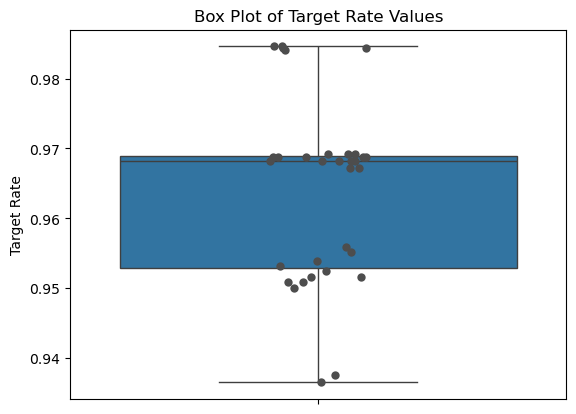

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=target_rate.values)

sns.stripplot(y=target_rate.values, size=6, color=".3")

plt.title('Box Plot of Target Rate Values')
plt.ylabel('Target Rate')

plt.show()

<AxesSubplot:>

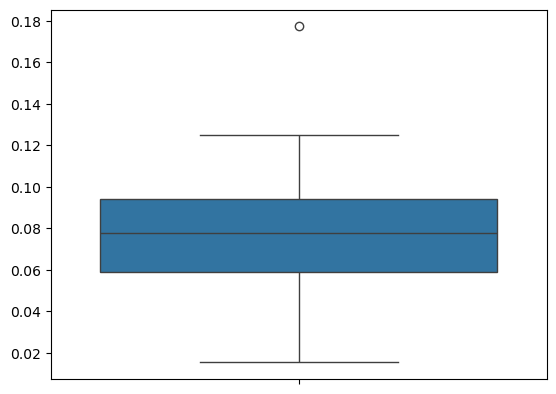

In [59]:
sns.boxplot(y=collision_rate.values)

In [98]:
# Filter the DataFrame to include only the rows where target is 1
df_target = df[df['target'] == 1]

# Get the statistics of the reward and progress_buf columns
reward_stats = df_target['reward'].describe()
progress_buf_stats = df_target['progress_buf'].describe()

print("Statistics of the reward column when target is 1:")
print(reward_stats)
print()

print("Statistics of the progress_buf column when target is 1:")
print(progress_buf_stats)

Statistics of the reward column when target is 1:
count     1960.000000
mean     15005.056689
std          0.568543
min      15002.818359
25%      15004.695068
50%      15005.063477
75%      15005.542480
max      15005.968750
Name: reward, dtype: float64

Statistics of the progress_buf column when target is 1:
count    1960.000000
mean       82.460204
std        14.975374
min        60.000000
25%        72.000000
50%        80.000000
75%        89.000000
max       232.000000
Name: progress_buf, dtype: float64


/tmp/ipykernel_83943/4231946818.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_target['reward'], kde=False)


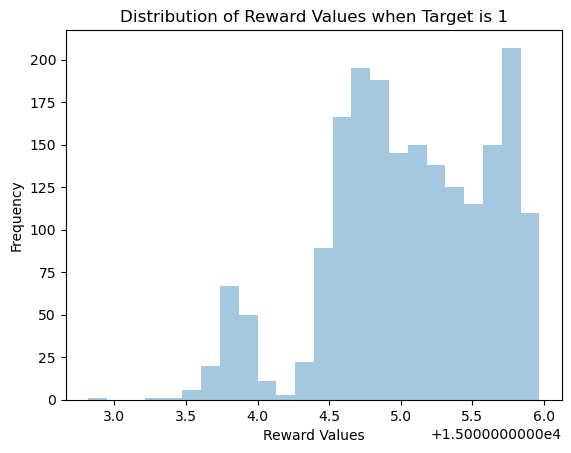

/tmp/ipykernel_83943/4231946818.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_target['progress_buf'], kde=False)


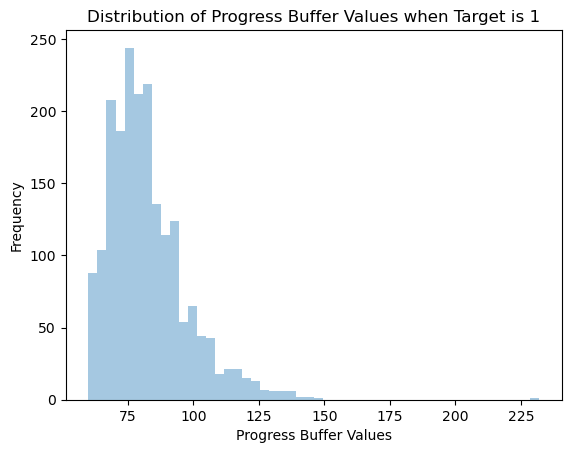

In [99]:
# Create a distribution plot of the reward column when target is 1
sns.distplot(df_target['reward'], kde=False)
plt.title('Distribution of Reward Values when Target is 1')
plt.xlabel('Reward Values')
plt.ylabel('Frequency')
plt.show()

# Create a distribution plot of the progress_buf column when target is 1
sns.distplot(df_target['progress_buf'], kde=False)
plt.title('Distribution of Progress Buffer Values when Target is 1')
plt.xlabel('Progress Buffer Values')
plt.ylabel('Frequency')
plt.show()